### Here we will estimate the minimum SN rate observable

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import swordfish as sf
from random import *
from tqdm import tqdm
import scipy.interpolate as interpolate
from scipy.integrate import quad
import paleopy as paleopy
from WIMpy import DMUtils as DMU
from scipy.special import gamma

rc('text', usetex=True)
rc('font',**{'family':'sans-serif','sans-serif':['cmr']})
rc('font',**{'family':'serif','serif':['cmr']})
rc('font', size=16)

In [3]:
# Fermi-Dirac spectrum
def dNdE(E, Etot, T, alpha):
    # E is the list of energies [keV]
    # T is the neutrino temperature [keV]
    # Etot is the total energy emitted in the CC supernova [kev]
    # dNdE in keV^-1
#     dom = np.exp(E/T) + 1
#     return Etot*120.*(E**2.)/7./(np.pi**4.)/(T**4.)/dom
    numer = Etot*((1+alpha)**(1+alpha))*(E**alpha)*np.exp(-(1+alpha)*E/T)
    return numer/gamma(1+alpha)/(T**(2+alpha))

In [4]:
def inverse_transform_sampling(function, x_range, nbins=100, n_samples=1000):
    bins = np.linspace(x_range[0], x_range[-1], num=nbins)
    pdf = function(np.delete(bins,-1) + np.diff(bins)/2)
    Norm = np.sum(pdf*np.diff(bins))
    pdf /= Norm
    cum_values = np.zeros(bins.shape)
    cum_values[1:] = np.cumsum(pdf*np.diff(bins))
    inv_cdf = interpolate.interp1d(cum_values, bins)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

In [5]:
R_E = 8.12 # kpc - Table A1 in 1807.09409 

def calc_f():
    R_gal = 50
    N_SN = int(1e5)
    
    def calc_dist(x, y, z):
        x_E = R_E
        y_E = 0.0
        z_E = 0.0
        return np.sqrt((x-x_E)**2+(y-y_E)**2+(z-z_E)**2)
    
    phi = np.random.uniform(0,2*np.pi, size=N_SN)
    z = np.random.exponential(scale=0.33, size=N_SN)
    
    # https://arxiv.org/abs/1612.07781
    l_c = 2.5 #kpc
    r_B = 2.0 #kpc
    sigma_0 = 611e6 #Msun/kpc^2

    def sigma_disc(r):
        #return r*sigma_0*l_c*((r-r_B)**2 + l_c**2)**-0.5
        r_d = 2.9 #kpc
        return r*np.exp(-r/r_d)

    x_temp = np.linspace(0,R_gal,num=100)
    r = inverse_transform_sampling(sigma_disc, x_temp, nbins=100, n_samples=N_SN)
    
    theta = np.pi/2.
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    
    for i in tqdm(range(N_SN)):
        R = calc_dist(x, y, z)
        
    b_edge = np.linspace(0,R_gal,100)
    b_c = b_edge[:-1] + np.diff(b_edge)/2
    dist_bin = np.histogram(R, bins=b_edge, normed=True)
    
    f = interpolate.interp1d(b_c, dist_bin[0], bounds_error=False, fill_value=(0.0,0.0))
    return f

100%|██████████| 100000/100000 [00:49<00:00, 2018.54it/s]
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


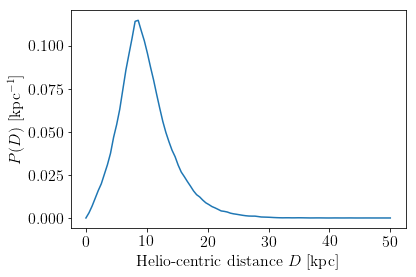

/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [6]:
def galactic_SN(E):
    T_v = np.array([13.3e3,14.6e3,15.0e3,15.0e3,15.0e3,15.0e3]) # keV
    Etot = np.array([6.0e52,4.3e52,2.0e52,2.0e52,2.0e52,2.0e52]) # ergs
    alpha = np.array([3., 3.3, 3., 3., 3., 3.])
#     T_v = np.array([13.3e3,13.3e3,13.3e3,13.3e3,13.3e3,13.3e3])
#     Etot = np.array([6.0e52,6.0e52,6.0e52,6.0e52,6.0e52,6.0e52])
    Etot *= 6.242e+8 # ergs to keV
    F = calc_f()
    
    xlist = np.linspace(0, 50, 100)
    plt.figure()
    plt.plot(xlist, F(xlist))
    plt.xlabel(r"Helio-centric distance $D$ [kpc]")
    plt.ylabel(r"$P(D)$ [kpc$^{-1}$]")
    plt.show()
    
    dist_weight = lambda R: F(R)/4/np.pi/((R)**2.) 
    dndE = np.zeros_like(E)
    for i in range(6):
        dndE += dNdE(E, Etot[i], T_v[i], alpha[i])
    dNdE_gal = dndE*quad(dist_weight, 0., 30)[0]/(3.086e+21**2) # Convert kpc^-2 to cm^-2
    # returns in s^-1 keV^-1 cm^-2 - assuming one CC SN per second
    return dNdE_gal
    

Elist = np.logspace(-1,6,1000) # keV
dndE = galactic_SN(Elist)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


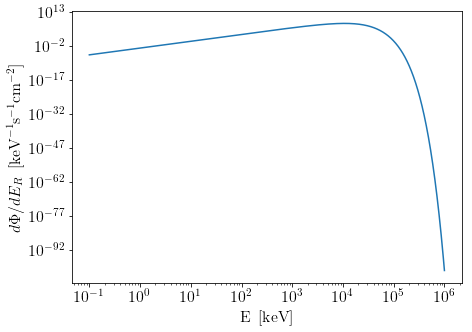

In [7]:
plt.figure(figsize=(7,5))
plt.loglog(Elist,dndE)
plt.ylabel(r"$d\Phi/dE_R~\, [\mathrm{keV}^{-1}\mathrm{s}^{-1}\mathrm{cm}^{-2}]$")
plt.xlabel(r"$\mathrm{E}~\, [\mathrm{keV}]$")
# plt.ylim(0.0001,4.)
plt.show()

### Lets transform this into a recoil spectra

In [8]:
dndE_gal = interpolate.interp1d(Elist*1e-3, dndE*1e3, bounds_error=False, fill_value=(0.0,0.0)) # converting keV --> MeV

In [9]:
Epso = paleopy.Mineral("Epsomite")
dRdE = np.zeros_like(dndE)

x = 0
for nuc in Epso.nuclei:
    dRdE += Epso.ratio_nuclei[nuc]*(np.vectorize(DMU.dRdE_CEvNS)(Elist, Epso.N_p[x], Epso.N_n[x],
                                                                 flux_name="user", flux_func = dndE_gal))
    x += 1
    
# returns values in keV^-1 kg^-1 day^-1

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


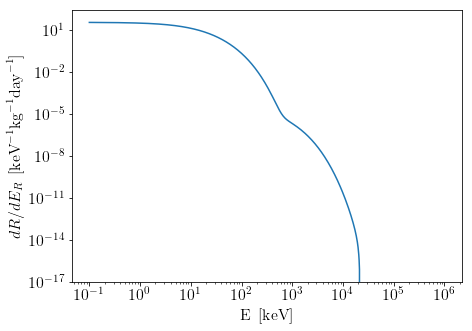

In [10]:
plt.figure(figsize=(7,5))
plt.loglog(Elist,dRdE)
plt.ylabel(r"$dR/dE_R~\, [\mathrm{keV}^{-1}\mathrm{kg}^{-1}\mathrm{day}^{-1}]$")
plt.xlabel(r"$\mathrm{E}~\, [\mathrm{keV}]$")
# plt.savefig("../plots/recoil_rate_galactic.pdf", bbox_inches="tight")
plt.show()

### Now lets calculate the track length spectra

Mineral name: Epsomite
    N_nuclei: 4
    Molar mass: 246.3  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    Mg		*	0.09866017052375152	*	(12.0, 12.3)
    S		*	0.12992285830288267	*	(16.0, 16.0)
    O		*	0.7145757206658546	*	(8.0, 8.0)
    H		*	0.05684125050751116	*	(1.0, 0.0)
Plotting SRIM data for Epsomite:


/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


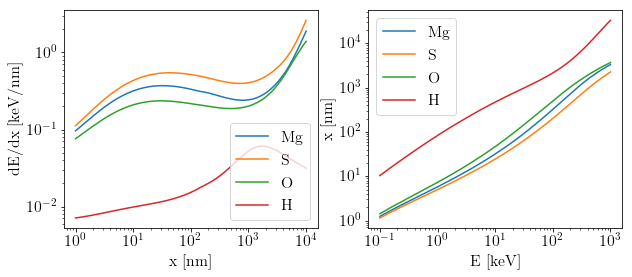

In [11]:
Epso.showProperties()
Epso.showSRIM()

In [12]:
x0 = 15.0/2.0
x = np.logspace(0,3,num=200)

dRdx_temp = np.zeros_like(x)
for i, nuc in enumerate(Epso.nuclei):
    if (nuc != "H"):
        xtemp = Epso.Etox_nuclei[nuc](Elist)
        dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(Elist, Epso.N_p[i], Epso.N_n[i], flux_name="user", flux_func = dndE_gal)
                                            *Epso.dEdx_nuclei[nuc](xtemp))
        temp_interp = interpolate.interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
        dRdx_temp += Epso.ratio_nuclei[nuc]*temp_interp(x)
    
dRdx = dRdx_temp*1e6*365+1e-20 # kg/Myr/nm
dRdx_interp = interpolate.interp1d(x, dRdx, fill_value='extrapolate')

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


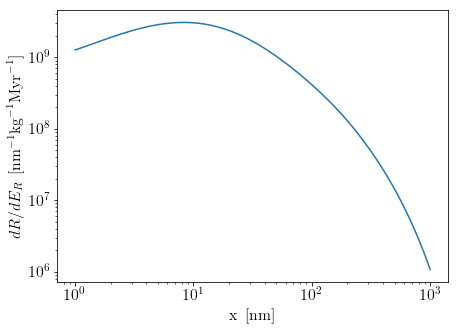

In [13]:
plt.figure(figsize=(7,5))
plt.loglog(x,dRdx)
plt.ylabel(r"$dR/dE_R~\, [\mathrm{nm}^{-1}\mathrm{kg}^{-1}\mathrm{Myr}^{-1}]$")
plt.xlabel(r"$\mathrm{x}~\, [\mathrm{nm}]$")
# plt.ylim(0.1,100)
# plt.savefig("../plots/tracklength_spectra_galactic.pdf", bbox_inches="tight")
plt.show()

### Finally, we can estimate the minimum rate required to be detectable

In [14]:
def MakeSF(mineral, sigma, exposure):
    systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
    dRdx_BG = paleopy.GetBackground(mineral, sigma)
    SF = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*exposure)
    return SF, dRdx_BG

print("Catching some Swordfish with Epsomite...")
SF_Epso_15nm, Epso_bkg = MakeSF(Epso, 15.0, 100.)
print("...done.")

Catching some Swordfish with Epsomite...
 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
    pp
    7Be-384
    7Be-861
...done.


/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


...done.


In [15]:
from scipy.special import erf
def window(x, x_a, x_b, sigma):
    return 0.5*(erf((x - x_a)/(np.sqrt(2.0)*sigma)) - erf((x - x_b)/(np.sqrt(2.0)*sigma)))

sigma = 15.
x = np.logspace(np.log10(x0), 3, 70)
#x = np.linspace(x0, 1000, 70)

x_c = x[:-1] + np.diff(x)/2
dRdx_binned = np.zeros_like(x_c)

for i in tqdm(range(x_c.size)):
    x1 = x_c[i] - 5.0*sigma
    x2 = x_c[i] + 5.0*sigma
    x1 = np.clip(x1, 0.1, 1e5)
    intge = lambda y: dRdx_interp(y)*window(y, x[i], x[i+1], sigma)
    dRdx_binned[i] = quad(intge, x1, x2)[0] + 1e-30

  0%|          | 0/69 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
/usr/local/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
100%|██████████| 69/69 [00:06<00:00, 11.38it/s]


In [16]:
significance = np.logspace(-8,-1,50)
R = np.zeros_like(significance)

for i, s in enumerate(significance):
    R[i] = SF_Epso_15nm.discoveryreach(dRdx_binned,s)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


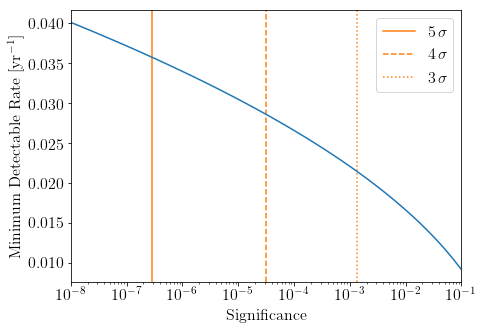

In [17]:
A0 = 1 # s^-1
A0 *= 1*365*1e6*86400 # Myr^-1
R_peryer = R*A0/1e6 # yr^-1

plt.figure(figsize=(7,5))

plt.axvline(x=2.87e-7, color='C1', label=r'$5 \,\sigma$')
plt.axvline(x=3.167e-05, color='C1', linestyle='--', label=r'$4 \,\sigma$')
plt.axvline(x=0.00135, color='C1', linestyle=':', label=r'$3 \,\sigma$')
plt.semilogx(significance, R_peryer)
plt.xlim(1e-8,1e-1)
plt.xlabel(r'Significance')
plt.ylabel(r'Minimum Detectable Rate [$\textrm{yr}^{-1}$]')
plt.legend()
# plt.savefig('../plots/R_min_vs_sig.pdf', bbox_inches='tight')
plt.show()

------------------------

## Detectable R_SN as a function of t_age and C_238

In [18]:
load_from_file = True

In [19]:
def calc_signal(mineral):
    x0 = 15.0/2.0
    x = np.logspace(0,3,num=200)

    dRdx_temp = np.zeros_like(x)
    for i, nuc in enumerate(mineral.nuclei):
        if (nuc != "H"):
            xtemp = mineral.Etox_nuclei[nuc](Elist)
            dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(Elist, mineral.N_p[i], mineral.N_n[i], flux_name="user", flux_func = dndE_gal)
                                                *mineral.dEdx_nuclei[nuc](xtemp))
            temp_interp = interpolate.interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
            dRdx_temp += mineral.ratio_nuclei[nuc]*temp_interp(x)

    dRdx = dRdx_temp*1e6*365+1e-20 # kg/Myr/nm
    dRdx_interp = interpolate.interp1d(x, dRdx, fill_value='extrapolate')
    
    sigma = 15.
    x = np.logspace(np.log10(x0), 3, 70)
    x_c = x[:-1] + np.diff(x)/2
    dRdx_binned = np.zeros_like(x_c)

    for i in range(x_c.size):
        x1 = x_c[i] - 5.0*sigma
        x2 = x_c[i] + 5.0*sigma
        x1 = np.clip(x1, 0.1, 1e5)
        intge = lambda y: dRdx_interp(y)*window(y, x[i], x[i+1], sigma)
        dRdx_binned[i] = quad(intge, x1, x2)[0] + 1e-30
    
    return dRdx_binned

In [20]:
#t_age in Gyr
#Default significance is 3-sigma
def CalcDetectableR(t_age, C_238, miner="Epsomite", sigma=15.0, significance=0.00135):
    mineral = paleopy.Mineral(miner)
    mineral.U_frac = C_238
    
    exposure = 0.1*(t_age*1e3) #100g x t_age (exposure should be in kg Myr, t_age is in Gyr)
    
    systematics = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1e-2, 1e-2]
    
    dRdx_BG = paleopy.GetBackground(mineral, sigma)
    SF = sf.Swordfish(dRdx_BG, T=systematics, E=np.ones_like(dRdx_BG[0])*exposure)
    
    #Normalisation of SN rate in signal calculation
    #is fixed to 1/s.
    signal = calc_signal(mineral)
    Rate_per_second = SF.discoveryreach(signal,significance)
    Rate_per_Myr = Rate_per_second*1*365*86400
    return Rate_per_Myr

** As a function of t_age **

In [21]:
load_from_file = True

if (load_from_file):
    t_age_list, R_det_age_Halite, R_det_age_Epsomite, R_det_age_Nchwaningite, R_det_age_Olivine = np.loadtxt("../data/results/R_det_vs_age.txt", unpack = True)
    R_detect_age = {}
    R_detect_age["Halite"] = R_det_age_Halite
    R_detect_age["Epsomite"] = R_det_age_Epsomite
    R_detect_age["Nchwaningite"] = R_det_age_Nchwaningite
    R_detect_age["Olivine"] = R_det_age_Olivine

else:
    minerals = ["Halite","Epsomite","Nchwaningite", "Olivine"]
    C_list = [1e-10, 1e-11, 1e-10, 1e-11]
    R_detect_age = {}

    for mine, C in zip(minerals, C_list):
        N_t = 30
        t_age_list = np.linspace(0.1, 1.0, N_t)
        R_det_age = 0.0*t_age_list

        for i in tqdm(range(N_t)):
            R_det_age[i] = CalcDetectableR(t_age_list[i], C_238=C, miner=mine)

        R_detect_age[mine] = R_det_age
        
    headertxt = "Detectable R_SN as a function of mineral age (100g, 15nm, C_238 = 1e-11)"
    headertxt += "\nColumns: t_age [Gyr], R_SN (Olivine) [yr^-1], R_SN (Halite) [yr^-1], R_SN (Epsomite) [yr^-1], R_SN (Nchwaningite) [yr^-1]"

    np.savetxt("../data/results/R_det_vs_age.txt", list(zip(t_age_list, R_detect_age[minerals[0]], R_detect_age[minerals[1]],
                                                            R_detect_age[minerals[2]], R_detect_age[minerals[3]])), header=headertxt)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_

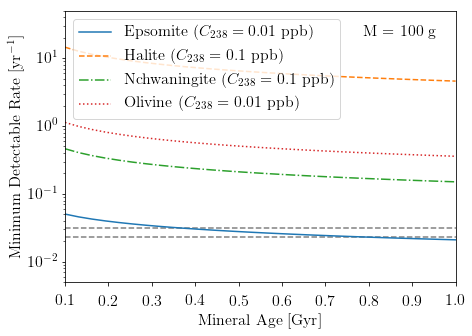

In [22]:
from itertools import cycle

plt.figure(figsize=(7,5))

plt.axhline(2.3e-2, linestyle='--', color='grey')
plt.axhline(3.2e-2, linestyle='--', color='grey')

minerals = ["Epsomite","Halite","Nchwaningite", "Olivine"]
labels =  ["Epsomite ($C_{238} = 0.01$ ppb)","Halite ($C_{238} = 0.1$ ppb)","Nchwaningite ($C_{238} = 0.1$ ppb)", "Olivine ($C_{238} = 0.01$ ppb)"]
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for mine,lab in zip(minerals, labels):
    plt.semilogy(t_age_list, R_detect_age[mine], label=lab, linestyle=next(linecycler))

plt.xlabel(r'Mineral Age [$\textrm{Gyr}$]')
plt.ylabel(r'Minimum Detectable Rate [$\textrm{yr}^{-1}$]')
#plt.legend()

plt.text(0.95, 0.95, "M = 100 g" ,
            va='top',ha='right', transform=plt.gca().transAxes)

plt.legend(loc=2)
#----------
plt.xlim(0.1,1.)
plt.xticks(np.linspace(0.1, 1.0, 10))

plt.ylim(5e-3, 50)
plt.gca().tick_params(axis='x', which='major', pad=8)

# plt.savefig('../plots/R_min_vs_tage_minerals.pdf', bbox_inches='tight')
plt.show()

**As a function of C_238 **

In [23]:
from itertools import cycle

if (load_from_file):
    C238_list, R_det_C238_Halite, R_det_C238_Epsomite, R_det_C238_Nchwaningite, R_det_C238_Olivine = np.loadtxt("../data/results/R_det_vs_C238.txt", unpack=True)
    R_detect_C238 = {}
    R_detect_C238["Epsomite"] = R_det_C238_Epsomite
    R_detect_C238["Halite"] = R_det_C238_Halite
    R_detect_C238["Nchwaningite"] = R_det_C238_Nchwaningite
    R_detect_C238["Olivine"] = R_det_C238_Olivine
    
else:
    minerals = ["Halite","Epsomite","Nchwaningite", "Olivine"]
    R_detect_C238 = {}
    
    for mine in minerals:
        N_C = 20
        C238_list = np.logspace(-3, 1, N_C)*1e-9
        R_det_C238 = 0.0*C238_list

        for i in tqdm(range(N_C)):
            R_det_C238[i] = CalcDetectableR(1.0, C238_list[i], miner=mine)

        R_detect_C238[mine] = R_det_C238
    
    headertxt = "Detectable R_SN as a function of U-238 concentration (Espomite, 100g, 15nm, t_age = 1 Gyr)"
    headertxt += "\nColumns: C_238 [Fraction by weight], R_SN (Olivine) [yr^-1], R_SN (Halite) [yr^-1], R_SN (Epsomite) [yr^-1], R_SN (Nchwaningite) [yr^-1]"

    np.savetxt("../data/results/R_det_vs_C238.txt", list(zip(C238_list, R_detect_C238[minerals[0]], R_detect_C238[minerals[1]],
                                                            R_detect_C238[minerals[2]], R_detect_C238[minerals[3]])), header=headertxt)

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


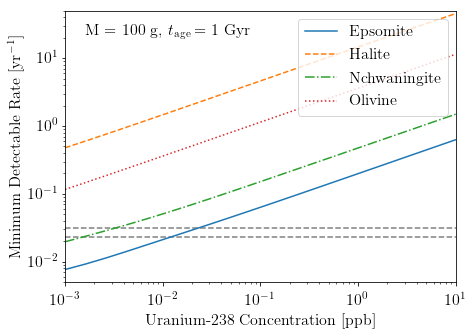

In [24]:
plt.figure(figsize=(7,5))

plt.axhline(2.3e-2, linestyle='--', color='grey')
plt.axhline(3.2e-2, linestyle='--', color='grey')

minerals = ["Epsomite","Halite","Nchwaningite", "Olivine"]
lines = ["-","--","-.",":"]
linecycler = cycle(lines)

for mine in minerals:
    plt.loglog(C238_list*1e9, R_detect_C238[mine], label=mine, linestyle=next(linecycler))

plt.xlabel(r'Uranium-238 Concentration [ppb]')
plt.ylabel(r'Minimum Detectable Rate [$\textrm{yr}^{-1}$]')
plt.legend(loc=1)

plt.text(0.05, 0.95, "M = 100 g, $t_\mathrm{age} = 1$ Gyr", 
            va='top',ha='left', transform=plt.gca().transAxes)

#------------

plt.xlim(1e-3,1e1)
plt.ylim(5e-3, 50)
plt.gca().tick_params(axis='x', which='major', pad=8)

# plt.savefig('../plots/R_min_vs_C238_minerals.pdf', bbox_inches='tight')
plt.show()